In [1]:
import numpy as np

In [2]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
import sklearn.datasets as dss

In [6]:
from datetime import datetime as dt

In [13]:
pdData = pd.read_csv('LogiReg_data.txt', header=None, names=['exam1','exam2','admitted'])
pdData.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [14]:
pdData.shape

(100, 3)

Text(0, 0.5, 'exam2 score')

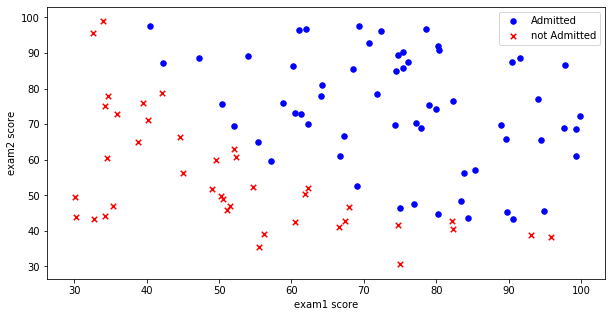

In [16]:
positive = pdData[pdData['admitted'] == 1]
negative = pdData[pdData['admitted'] == 0]

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(positive['exam1'], positive['exam2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['exam1'], negative['exam2'], s=30, c='r', marker='x', label='not Admitted')

ax.legend()

ax.set_xlabel('exam1 score')
ax.set_ylabel('exam2 score')

In [7]:
def sigmod(z):
    return 1 / (1 + np.exp(-z))

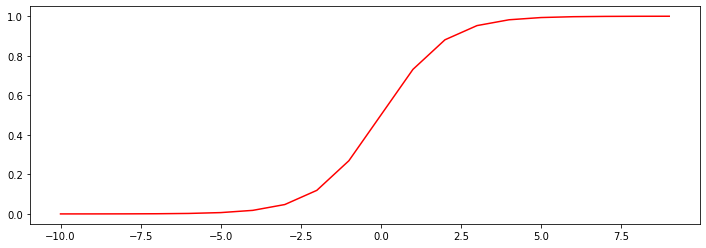

In [9]:
nums = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(nums, sigmod(nums), 'r')

In [10]:
def model(X, theta):
    return sigmod(np.dot(X, theta.T))

In [21]:
print(pdData)
#pdData.insert(0, 'ones', 1)
#print(pdData)
origin_data = pdData.as_matrix()
cols = origin_data.shape[1]
X = origin_data[:,0:cols-1]
y = origin_data[:,cols-1:cols]
print(X)
print(y)

    ones      exam1      exam2  admitted
0      1  34.623660  78.024693         0
1      1  30.286711  43.894998         0
2      1  35.847409  72.902198         0
3      1  60.182599  86.308552         1
4      1  79.032736  75.344376         1
5      1  45.083277  56.316372         0
6      1  61.106665  96.511426         1
7      1  75.024746  46.554014         1
8      1  76.098787  87.420570         1
9      1  84.432820  43.533393         1
10     1  95.861555  38.225278         0
11     1  75.013658  30.603263         0
12     1  82.307053  76.481963         1
13     1  69.364589  97.718692         1
14     1  39.538339  76.036811         0
15     1  53.971052  89.207350         1
16     1  69.070144  52.740470         1
17     1  67.946855  46.678574         0
18     1  70.661510  92.927138         1
19     1  76.978784  47.575964         1
20     1  67.372028  42.838438         0
21     1  89.676776  65.799366         1
22     1  50.534788  48.855812         0
23     1  34.212

In [22]:
theta = np.zeros([1,3])

In [26]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))

In [27]:
cost(X , y, theta)

0.6931471805599453

In [28]:
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(X, theta) - y).ravel()
    for j in range(len(theta.ravel())):
        term = np.multiply(error, X[:,j])
        grad[0, j] = np.sum(term) / len(X)
    return grad

In [29]:
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    if type == STOP_ITER:
        return value > threshold
    elif type == STOP_COST:
        return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:
        return np.linalg.norm(value) < threshold

In [35]:
import numpy.random

def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return X, y

In [31]:
import time

def descent(data, theta, batchsize, stopType, thresh, alpha):
    
    init_time = time.time()
    
    i = 0
    k = 0
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape)
    costs = [cost(X, y, theta)]
    
    while True:
        grad = gradient(X[k:k+batchsize], y[k:k+batchsize], theta)
        k += batchsize
        if k >= n:
            k = 0
            X, y = shuffleData(data)
        theta = theta - alpha*grad
        costs.append(cost(X, y, theta))
        
        i += 1
        
        if stopType == STOP_ITER:
            value = i
        elif stopType == STOP_COST:
            value = costs
        elif stopType == STOP_GRAD:
            value = grad
        
        if stopCriterion(stopType, value, thresh):
            break
            
    return theta, i - 1, costs, grad, time.time() - init_time

In [32]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 1.50s


array([[-0.00027127,  0.00705232,  0.00376711]])

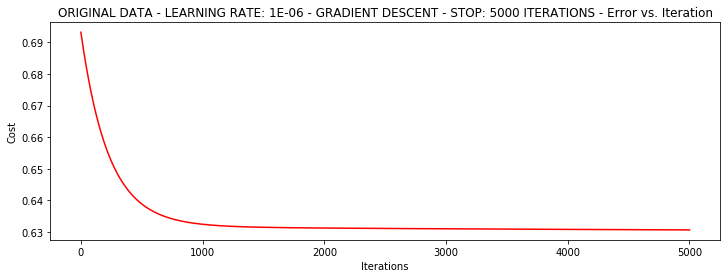

In [36]:
n=100
runExpe(origin_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)